In [1]:
%matplotlib inline 
import torch
import torch.optim as optim
from torchvision import transforms, models
#transforms for image transforms and models for transfer learning(using pretraomed model)
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)
    #do not update weight

In [19]:
#use GPU if availabe
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)
#its a summery and fc layers are not listed

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [20]:
#we have a content image and a style image...target image will be combination of these two
#max image = 400 h and w to speedup the process
#shape-->control shape of image
def load_image(img_path, max_size=400, shape=None):
    #open image and set color space to RGB
    image = Image.open(img_path).convert('RGB')
    #max(image.size)-->highest dim(w or h)
    if max(image.size) > max_size:
        size = max_size#change the size
    else:
        size = max(image.size)#unchanged
    
    if shape is not None:#for making both content and style having same dims
        size = shape
 
    in_transform = transforms.Compose([
                        transforms.Resize(size), #max will be 400
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), #normalize image
                                             (0.5, 0.5, 0.5))])

    image = in_transform(image).unsqueeze(0)
    
    return image

In [21]:
content = load_image('messi.jpg').to(device)
style = load_image('StarryNight.jpg',shape=content.shape[-2:]).to(device)
#making both content and style having same dims
#third and fourh index of the image will be dims we need-->[-2:]

In [22]:
#convert our images from tensors into numpy images so we can use pyplot to visualize our image
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)

    return image

(-0.5, 726.5, 399.5, -0.5)

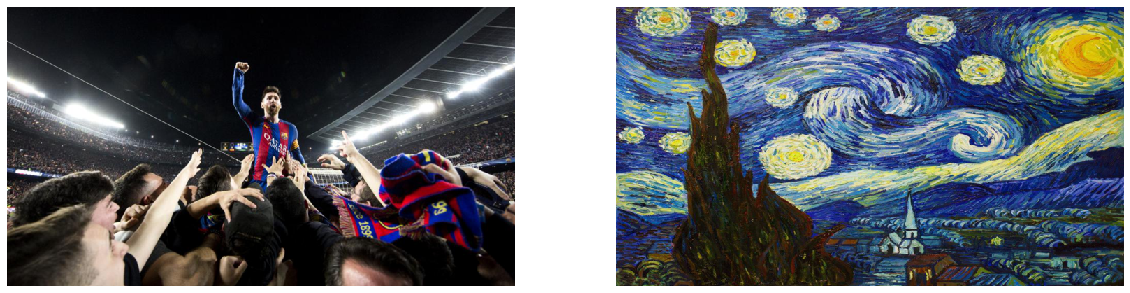

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))#single row and 2 columns
#fixed size of 20*10
ax1.imshow(im_convert(content))
ax1.axis("off")
ax2.imshow(im_convert(style))
ax2.axis("off")

In [24]:
def get_features(image, model):
   #we want the content features of the target image to match features of content image
   #we want the style features of the target image to match features of style image 
    layers = {'0': 'conv1_1',
              '5': 'conv2_1', 
              '10': 'conv3_1', 
              '19': 'conv4_1',
              '21': 'conv4_2',  #content feature extraction
              '28': 'conv5_1'}
#paper recommand using these layers as features
#we use 5 of these for style extraction
#use 1 of them for content extraction-->conv4-2 because its deep enough to provide high depth features
        
    features = {}
#name is 0,5,10...
    for name, layer in model._modules.items():
        image = layer(image)#feed our image to network
        if name in layers:#store feature that we stored earlier
            features[layers[name]] = image
            
    return features

In [25]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [26]:
#style transfer needs preprocess for better effect
#gram=v^t v
#it help to create texture information related to data
def gram_matrix(tensor):
    _, d, h, w = tensor.size()#batch size(not using this),image depth,height,weight
    tensor = tensor.view(d, h * w)#d is num of feature channels
    gram = torch.mm(tensor, tensor.t())
    return gram

In [27]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
#grams for each layers

In [28]:
#earlier layers are more effective
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha--->content image weight
style_weight = 1e6  # beta-->style image weight

In [29]:
target = content.clone().requires_grad_(True).to(device)
#we want this target image to adjusted during our optimization process
#at first we initilized it as content image

In [30]:
show_every = 300 #show target image 
optimizer = optim.Adam([target], lr=0.003)
steps = 2100

height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))#to make video at the end of the process
#300 frames
capture_frame = steps/300 #capture frame evey 7 step
counter = 0 #keep tracks of array index

Total loss:  1599752.875
Iteration:  300


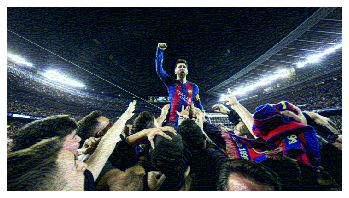

Total loss:  699682.3125
Iteration:  600


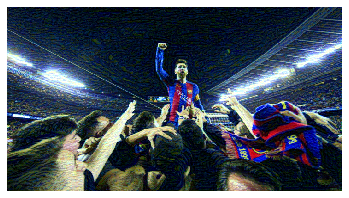

Total loss:  463124.78125
Iteration:  900


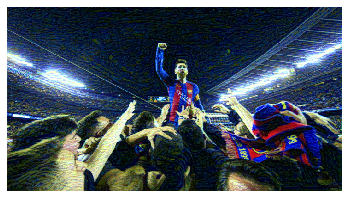

Total loss:  330020.6875
Iteration:  1200


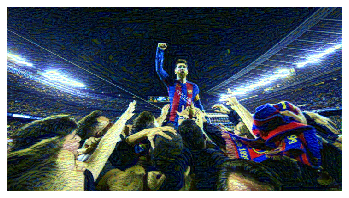

Total loss:  243884.296875
Iteration:  1500


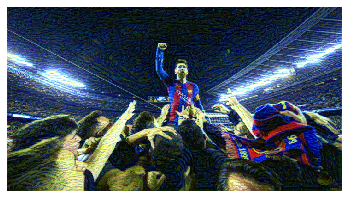

Total loss:  183972.46875
Iteration:  1800


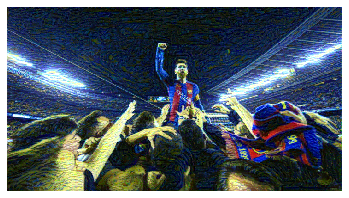

Total loss:  140504.515625
Iteration:  2100


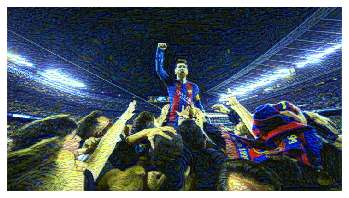

In [31]:
#we have two goals:
  #first goal: for style and target make 2 gram matrices(target and updeted) equal
  #second goal:for content and target make the filtered images similar
for ii in range(1, steps+1):
    target_features = get_features(target, vgg)
    #mse
    #4-2 is content feature extreaction
    #content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    style_loss = 0
    #style loss
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        # *style_weights[layer] use weights we mentioned before
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        _, d, h, w = target_feature.shape
        style_loss += layer_style_loss / (d * h * w)#we need unit loss
  
    total_loss = content_weight * content_loss + style_weight * style_loss
  
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
  
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        print('Iteration: ', ii)
        plt.imshow(im_convert(target))
        plt.axis("off")
        plt.show()
    
    if ii % capture_frame == 0:
        image_array[counter] = im_convert(target)
        counter = counter + 1

(-0.5, 726.5, 399.5, -0.5)

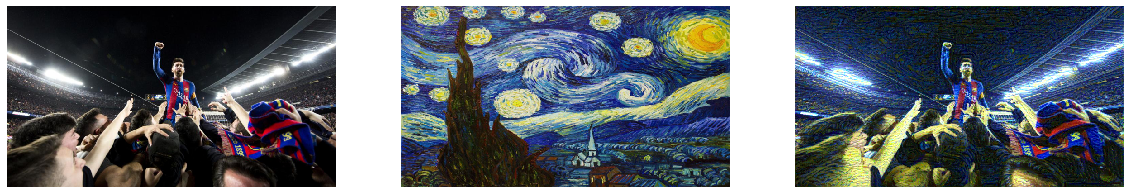

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')
ax3.imshow(im_convert(target))
ax3.axis('off')

In [34]:
import cv2 

frame_height, frame_width, _ = im_convert(target).shape
vid = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))

for i in range(0, 300):
    img = image_array[i]
    img = img*255
    img = np.array(img, dtype = np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    vid.write(img)

vid.release()

ModuleNotFoundError: No module named 'cv2'